In [1]:
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

points = client.retrieve(
    collection_name="log_sessions",
    ids=[0],  # any point id
    with_vectors=True,
    with_payload=True,
)

print("Payload:", points[0].payload)
print("Vector dim:", len(points[0].vector))
print("Vector (first 10):", points[0].vector[:10])

Payload: {'session_id': '00056990-8a66-5ff3-983e-94a5e16dd4b4', 'src_ip': '167.94.138.124', 'tool': 'browser/unknown', 'label': 'suspicious', 'suspicious_score': 0.6668454378972472, 'event_count': 3, 'rps': 3.0, 'indicator_hits': 2, 'start_ts': '2023-07-04T16:45:10+00:00', 'end_ts': '2023-07-04T16:45:11+00:00'}
Vector dim: 1024
Vector (first 10): [-0.03903617, 0.012093889, 0.055709008, -0.021676002, -0.008263936, 0.014553479, -0.00899852, -0.004063025, 0.010904229, 0.0029530996]


In [2]:
import numpy as np
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

# Scroll points (limit for demo)
points, _ = client.scroll(
    collection_name="log_sessions",
    limit=500,  # keep small for t-SNE
    with_vectors=True,
    with_payload=True,
)

X = np.array([p.vector for p in points])
labels = [p.payload.get("label", "unknown") for p in points]

X.shape

(500, 1024)

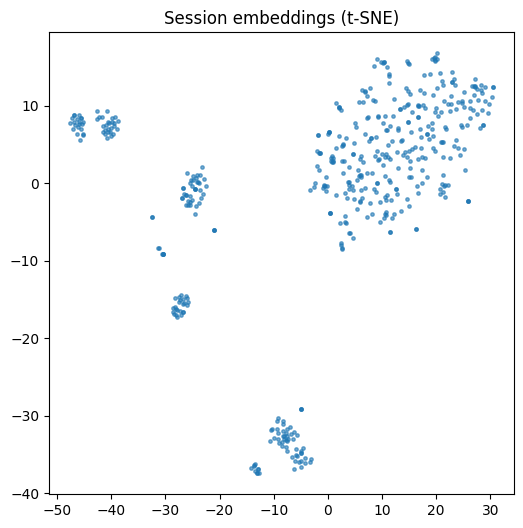

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_2d = TSNE(
    n_components=2, perplexity=30, learning_rate="auto", init="random", random_state=42
).fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=6, alpha=0.6)
plt.title("Session embeddings (t-SNE)")
plt.show()

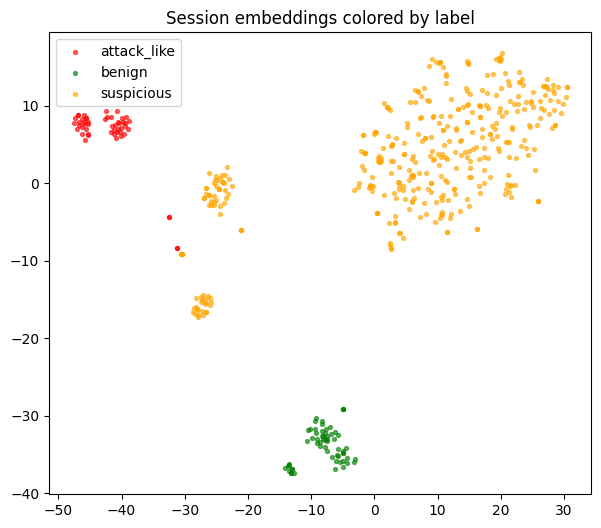

In [4]:
import pandas as pd

color_map = {
    "benign": "green",
    "attack_like": "red",
    "suspicious": "orange",
}

df = pd.DataFrame(X_2d, columns=["x", "y"])
df["label"] = labels

plt.figure(figsize=(7, 6))
for lbl, g in df.groupby("label"):
    plt.scatter(g.x, g.y, s=8, alpha=0.6, label=lbl, color=color_map.get(lbl, "gray"))

plt.legend()
plt.title("Session embeddings colored by label")
plt.show()

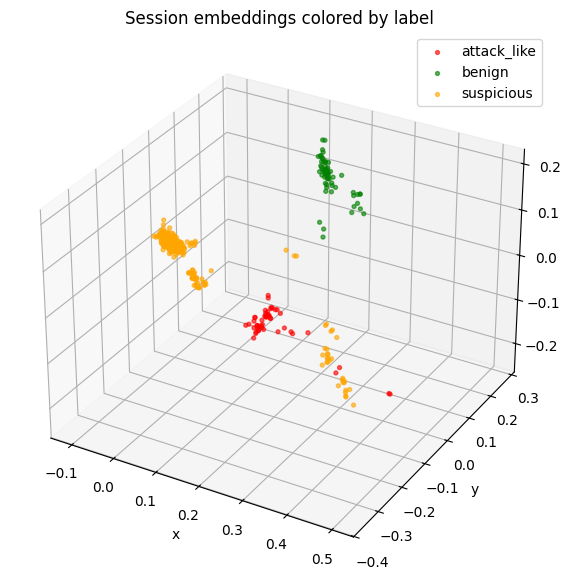

In [5]:
from sklearn.decomposition import PCA

color_map = {
    "benign": "green",
    "attack_like": "red",
    "suspicious": "orange",
}

# X is your original high‑dim embeddings (e.g., 384 dims)
X_3d = PCA(n_components=3, random_state=42).fit_transform(X)

df = pd.DataFrame(X_3d, columns=["x", "y", "z"])
df["label"] = labels

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

for lbl, g in df.groupby("label"):
    ax.scatter(
        g.x, g.y, g.z, s=8, alpha=0.6, label=lbl, color=color_map.get(lbl, "gray")
    )

ax.set_title("Session embeddings colored by label")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

In [6]:
client = QdrantClient(url="http://localhost:6333")

cols = client.get_collections().collections
[c.name for c in cols]
for name in ["mitre_attack", "log_sessions"]:
    info = client.get_collection(name)
    print(
        name, "| points:", info.points_count, "| vectors:", info.config.params.vectors
    )

mitre_attack | points: 835 | vectors: size=1024 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=None
log_sessions | points: 12097 | vectors: size=1024 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=None


In [7]:
# run attack
from src.rag.retrieve import search_attack_for_text

hits = search_attack_for_text(
    "directory brute force enumeration gobuster scanning",
    top_k=10,
    embed_model="sentence-transformers/all-roberta-large-v1",
    device="auto",
)

for h in hits[:10]:
    p = h.payload
    print(
        f"{h.score:.3f}  {p['technique_id']}  {p['name']}  tactics={p.get('tactics')}"
    )

d:\VScode\isea-rag-attack-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 Embeddings device selected: cpu


Loading weights: 100%|██████████| 391/391 [00:00<00:00, 524.74it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: sentence-transformers/all-roberta-large-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


0.439  T1083  File and Directory Discovery  tactics=['discovery']
0.384  T1564.012  File/Path Exclusions  tactics=['defense-evasion']
0.375  T1595.003  Wordlist Scanning  tactics=['reconnaissance']
0.374  T1560.001  Archive via Utility  tactics=['collection']
0.365  T1005  Data from Local System  tactics=['collection']
0.351  T1110  Brute Force  tactics=['credential-access']
0.346  T1518.002  Backup Software Discovery  tactics=['discovery']
0.340  T1140  Deobfuscate/Decode Files or Information  tactics=['defense-evasion']
0.339  T1222.002  Linux and Mac File and Directory Permissions Modification  tactics=['defense-evasion']
0.330  T1025  Data from Removable Media  tactics=['collection']


In [8]:
import pandas as pd
from src.rag.retrieve import search_sessions

hits = search_sessions(
    "etc passwd traversal lfi attempt",
    top_k=10,
    label="attack_like",  # try "suspicious" too
    tool="gobuster",  # or None
    embed_model="sentence-transformers/all-roberta-large-v1",
    device="auto",
)

rows = []
for h in hits:
    p = h.payload
    rows.append(
        {
            "score": round(h.score, 3),
            "session_id": p.get("session_id"),
            "src_ip": p.get("src_ip"),
            "label": p.get("label"),
            "tool": p.get("tool"),
            "suspicious_score": p.get("suspicious_score"),
            "event_count": p.get("event_count"),
            "start_ts": p.get("start_ts"),
        }
    )

pd.DataFrame(rows)

🔧 Embeddings device selected: cpu


Loading weights: 100%|██████████| 391/391 [00:00<00:00, 480.25it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: sentence-transformers/all-roberta-large-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


,score,session_id,src_ip,label,tool,suspicious_score,event_count,start_ts
0,0.256,d9a0d430-4385-554e-999d-04622b5d9209,49.34.106.190,attack_like,gobuster,0.891312,8,2023-01-09T10:04:12+00:00
1,0.255,743a9a34-bceb-533a-8fc3-8c30639337d3,199.188.238.77,attack_like,gobuster,0.979354,115716,2024-02-09T13:58:36+00:00
2,0.254,5d506a84-dfcc-59a2-bfee-c802f6ae90fd,106.205.210.163,attack_like,gobuster,0.977003,9184,2024-01-19T06:51:06+00:00
3,0.252,4ec55fc7-576d-5250-ada7-e130d988bb6b,143.244.44.163,attack_like,gobuster,0.986002,20407,2024-01-24T08:46:52+00:00
4,0.252,0bd19db5-97b8-527d-a725-fd5303b6ca5c,103.111.33.197,attack_like,gobuster,0.983519,309913,2024-02-09T15:19:23+00:00
5,0.251,040cce28-ec86-509f-a3cc-5a3142b750e2,152.58.39.230,attack_like,gobuster,0.879347,2,2024-01-19T02:34:38+00:00
6,0.250,fead1d1b-9bde-528b-a63b-c77e622d97ae,152.58.39.168,attack_like,gobuster,0.985082,4591,2024-01-19T02:36:46+00:00
7,0.250,50098038-418c-5415-a6d8-7440a07bb979,88.216.90.156,attack_like,gobuster,0.983201,5869,2024-02-08T11:59:19+00:00
8,0.250,c798b7df-827a-5c8f-87fe-3500dee82922,106.205.210.163,attack_like,gobuster,0.984506,4603,2024-01-19T05:25:27+00:00
9,0.249,1e5d31e9-50bd-54a1-85fe-e2df078ab6ff,152.58.34.93,attack_like,gobuster,0.879347,2,2024-01-30T07:53:39+00:00


In [9]:
pt = client.retrieve(
    collection_name="log_sessions", ids=[0], with_vectors=True, with_payload=True
)[0]

print("payload:", pt.payload)
print("vector_dim:", len(pt.vector))
print("vector_head:", pt.vector[:8])

payload: {'session_id': '00056990-8a66-5ff3-983e-94a5e16dd4b4', 'src_ip': '167.94.138.124', 'tool': 'browser/unknown', 'label': 'suspicious', 'suspicious_score': 0.6668454378972472, 'event_count': 3, 'rps': 3.0, 'indicator_hits': 2, 'start_ts': '2023-07-04T16:45:10+00:00', 'end_ts': '2023-07-04T16:45:11+00:00'}
vector_dim: 1024
vector_head: [-0.03903617, 0.012093889, 0.055709008, -0.021676002, -0.008263936, 0.014553479, -0.00899852, -0.004063025]


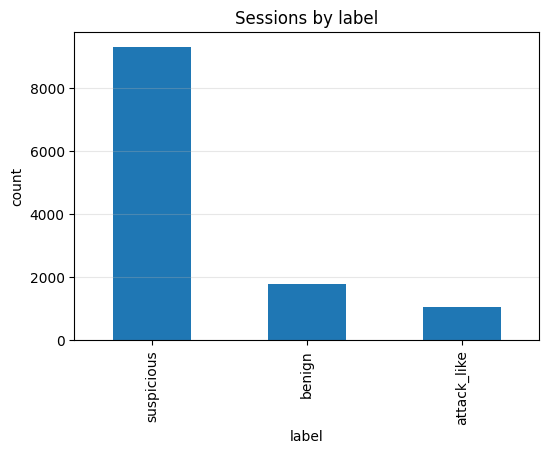

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

s = pd.read_parquet("../data/processed/sessions_scored.parquet")
vc = s["label"].value_counts()

plt.figure(figsize=(6, 4))
vc.plot(kind="bar")
plt.title("Sessions by label")
plt.ylabel("count")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [11]:
from src.rag.retrieve import search_attack_for_text
import pandas as pd

s = pd.read_parquet("../data/processed/sessions_scored.parquet")
row = s[s["label"].isin(["attack_like", "suspicious"])].iloc[0]  # pick one

query = f"""
src_ip={row.src_ip} tool={row.tool} label={row.label}
event_count={row.event_count} rps={row.rps} indicator_hits={row.indicator_hits}
reasons={row.get('rule_reasons', [])}
"""

hits = search_attack_for_text(
    query, top_k=8, embed_model="sentence-transformers/all-roberta-large-v1", device="auto"
)
[(round(h.score, 3), h.payload["technique_id"], h.payload["name"]) for h in hits]

🔧 Embeddings device selected: cpu


Loading weights: 100%|██████████| 391/391 [00:00<00:00, 527.17it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: sentence-transformers/all-roberta-large-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


[(0.502, 'T1592', 'Gather Victim Host Information'),
 (0.497, 'T1595.001', 'Scanning IP Blocks'),
 (0.497, 'T1059.009', 'Cloud API'),
 (0.48, 'T1059', 'Command and Scripting Interpreter'),
 (0.478, 'T1569.001', 'Launchctl'),
 (0.476, 'T1569.003', 'Systemctl'),
 (0.465, 'T1592.002', 'Software'),
 (0.463, 'T1562.006', 'Indicator Blocking')]